In [30]:
import numpy as np
from numpy import sin, cos, pi
import gym
import seagul.envs

from seagul.integration import rk4,euler
from control import lqr, ctrb
from torch.multiprocessing import Pool
import matplotlib.pyplot as plt
from itertools import product

from seagul.nn import MLP, fit_model
import torch

m1 = 1; m2 = 1
l1 = 1; l2 = 1
lc1 = .5; lc2 = .5
I1 = .2; I2 = 1.0
g = 9.8

Q = np.array([[1000, -500, 0,0],[-500, 1000, 0, 0],[0, 0, 1000, -500],[0,0,-500,1000]])
R = np.identity(2) * .5


dt = .01
max_torque = 5
integrator = rk4

eval_max_t = 10

th1 = pi / 2
th2 = 0
th1d = 0
th2d = 0

TAU = np.array([[0], [1]])

m11 = m1 * lc1 ** 2 + m2 * (l1 ** 2 + lc2 ** 2 + 2 * l1 * lc2 * cos(th2)) + I1 + I2
m22 = m2 * lc2 ** 2 + I2
m12 = m2 * (lc2 ** 2 + l1 * lc2 * cos(th2)) + I2
M = np.array([[m11, m12], [m12, m22]])

h1 = -m2 * l1 * lc2 * sin(th2) * th2d ** 2 - 2 * m2 * l1 * lc2 * sin(th2) * th2d * th1d
h2 = m2 * l1 * lc2 * sin(th2) * th1d ** 2
H = np.array([[h1], [h2]])

phi1 = (m1 * lc1 + m2 * l1) * g * cos(th1) + m2 * lc2 * g * cos(th1 + th2)
phi2 = m2 * lc2 * g * cos(th1 + th2)
PHI = np.array([[phi1], [phi2]])

Bl = np.linalg.inv(M) @ TAU
Blin = np.array([[0, 0], [0, 0], [0, Bl[0].item()], [0, Bl[1].item()]])

DPHI = np.array([[-g * (m1 * lc1 + m2 * l1 + m2 * lc2), -m2 * lc2 * g], [-m2 * lc2 * g, -m2 * lc2 * g]])
Al = -np.linalg.inv(M) @ DPHI
Alin = np.array([[0, 0, 1, 0], [0, 0, 0, 1], [Al[0, 0], Al[0, 1], 0, 0], [Al[1, 0], Al[1, 1], 0, 0]])

Ctr = ctrb(Alin, Blin)
assert np.linalg.matrix_rank(Ctr) == 4

K, S, E = lqr(Alin, Blin, Q, R)
k = np.array(K[1, :])
print("The balancing control law is u =- Kx, where k = %r" % k)


def control(q):
    gs = np.array([pi / 2, 0, 0, 0])
    return -k.dot(q - gs)


The balancing control law is u =- Kx, where k = array([[-1649.86567348,  -460.15780454,  -716.07110024,  -278.15312263]])


# Initial learning of the gating function

### We start by testing our LQR from a number of random initial conditions, and train a neural net to classify which states can be balanced and which cannot

In [31]:
# The reward function returns a done signal, to tell the environment that the trial is over
# in this we bail if the reward is negative, to avoid wasting time on trials that have already failed 
def reward_fn(s, a):
    reward = l1*np.sin(s[0]) + l2*np.sin(s[0] + s[1])
    done = reward < 0
    #done = False
    return reward, done


def do_rollout(args):
    x, trial_num = args
    th1, th2, dth1, dth2 = x
    np.random.seed(trial_num)
    local_reward_hist = np.ones((env.num_steps, 1)) * -1
    local_obs_hist = np.zeros((env.num_steps, 4))
    obs = env.reset(init_vec=[th1, th2, dth1, dth2])

    for i in range(env.num_steps):
        actions = np.clip(np.asarray(control(obs)), -max_torque, max_torque)
        obs, reward, done, _ = env.step(actions)
        local_reward_hist[i, :] = np.copy(reward)
        local_obs_hist[i,:] = np.copy(obs)
        if done:
            break
            
    err = np.sqrt(np.sum(((local_obs_hist[-10:, :] - np.array([pi / 2, 0, 0, 0])) ** 2),axis=1))
    return (err < .2).all(), i


config = { 
          "max_torque": max_torque,
          "init_state_weights": [0, 0, 0, 0],
          "max_t" : 2.5,
          "dt": dt,
          "m2": m2,
          "m1": m1,
          "l1": l1,
          "lc1": lc1,
          "lc2": lc2,
          "i1": I1,
          "i2": I2,
          "integrator" : integrator,
          "reward_fn": reward_fn,
          "act_hold": 1
          }

env = gym.make('su_acrobot-v0', **config)

num_trials = 500000

X = np.zeros((num_trials, 4), dtype=np.float32)
Y = np.zeros((num_trials, 1), dtype=np.float32)

# To speed things along we generate two sets of points, one that is centered around what we guess the region of attraction should be
# And one that included all possible initial conditions. The result is a data set with a higher density
# of points near where we expect the decision boundary to be you can certainly learn the gating function with only the second set of points.
# It just takes more data and more time,

th1_min = pi / 2 - .5
th1_max = pi / 2 + .5
th2_min = -1
th2_max = 1
th1dot_min = -5
th1dot_max = 5
th2dot_min = -10
th2dot_max = 10

samples = np.random.random_sample((int(num_trials/2), 4))
samples *= np.array([th1_min - th1_max, th2_min - th2_max, th1dot_min - th1dot_max, th2dot_min - th2dot_max])
samples += np.array([th1_max, th2_max, th1dot_max, th2dot_max])


total_steps = 0
pool = Pool()  # defaults to number of available CPU's
for i, res in enumerate(pool.imap(do_rollout, zip(samples, range(int(num_trials/2))))):
    y, steps = res
    total_steps += steps
    X[i, :] = samples[i, :]
    Y[i] = y

th1_min = 0
th1_max = 2*pi
th2_min = -pi
th2_max = pi
th1dot_min = -10
th1dot_max = 10
th2dot_min = -30
th2dot_max = 30

samples = np.random.random_sample((int(num_trials/2), 4))
samples *= np.array([th1_min - th1_max, th2_min - th2_max, th1dot_min - th1dot_max, th2dot_min - th2dot_max])
samples += np.array([th1_max, th2_max, th1dot_max, th2dot_max])
total_steps = 0

for i, res in enumerate(pool.imap(do_rollout, zip(samples, range(int(num_trials/2), int(num_trials))))):
    y, steps = res
    total_steps += steps
    X[i+int(num_trials/2), :] = samples[i, :]
    Y[i+int(num_trials/2)] = y
    

print("Supervised data generated")

Supervised data generated


100%|██████████| 50/50 [03:09<00:00,  3.79s/it]


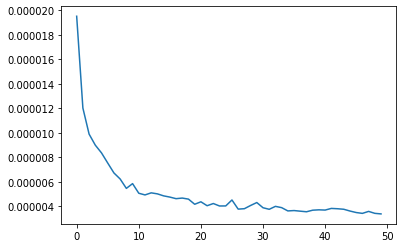

In [32]:
net = MLP(4, 1, 2, 32)

w = 1e-2 # Weighting parameter to encourage learning a conservative region of attraction
class_weight = torch.tensor(Y.shape[0]/sum(Y)*w, dtype=torch.float32)
# This is just doing some pretty standard supervised learning, the source is available in seagul
loss_hist = fit_model(net, X, Y, 50, batch_size=2048, loss_fn=torch.nn.BCEWithLogitsLoss(pos_weight=class_weight))

plt.close()
plt.plot(loss_hist)

# Gate Function Visualization

### Now we visualize the ouput of our gating function, as a sanity check, also gives us something to compare the final gating function to.

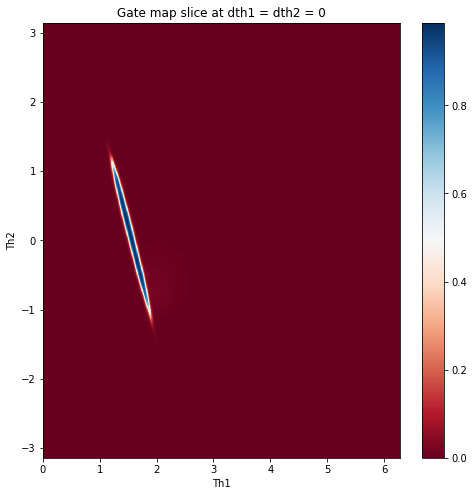

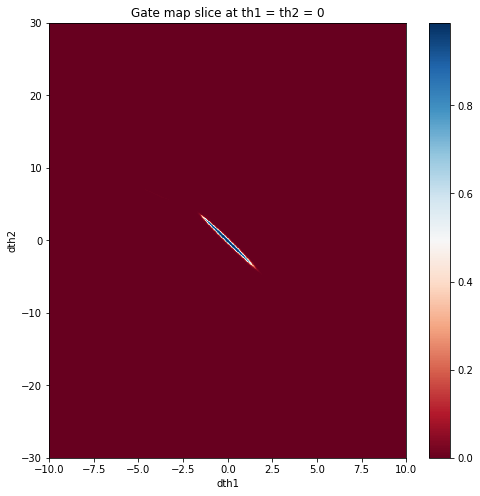

In [33]:
n_thdot = 1
n_th = 1000

th1_vals = np.linspace(0, 2*pi, n_th)
th2_vals = np.linspace(-pi, pi, n_th)

th1dot_vals = np.linspace(-10, 10, n_th)
th2dot_vals = np.linspace(-30, 30, n_th)


coords = np.zeros((n_th, n_th, 4), dtype=np.float32)
for i, j in product(range(n_th), range(n_th)):
    coords[j, i, :] = np.array([th1_vals[i], th2_vals[j], 0, 0])

    
sig = torch.nn.Sigmoid() #BCEWithLogits included the sigmoid layer for us, but we need to apply it ourselves outside that context
preds = sig(net(coords.reshape(-1, 4)).reshape(n_th, n_th).detach())

fig, ax = plt.subplots(n_thdot, n_thdot, figsize=(8, 8))
# generate 2 2d grids for the x & y bounds
x, y = np.meshgrid(th1_vals, th2_vals)
z = preds

# x and y are bounds, so z should be the value *inside* those bounds.
# Therefore, remove the last value from the z array.
z = z[:-1, :-1]
z_min, z_max = 0, np.abs(z).max()

c = ax.pcolormesh(x, y, z, cmap='RdBu', vmin=z_min, vmax=z_max)
ax.set_title('Gate map slice at dth1 = dth2 = 0')
ax.set_xlabel('Th1')
ax.set_ylabel('Th2')

# set the limits of the plot to the limits of the data
ax.axis([x.min(), x.max(), y.min(), y.max()])
fig.colorbar(c, ax=ax)
plt.show()

coords = np.zeros((n_th, n_th, 4), dtype=np.float32)

for i, j in product(range(n_th), range(n_th)):
    coords[j, i, :] = np.array([pi/2, 0, th1dot_vals[i], th2dot_vals[j]])

preds = sig(net(coords.reshape(-1, 4)).reshape(n_th, n_th).detach())

fig, ax = plt.subplots(n_thdot, n_thdot, figsize=(8, 8))
# generate 2 2d grids for the x & y bounds
x, y = np.meshgrid(th1dot_vals, th2dot_vals)
z = preds

# x and y are bounds, so z should be the value *inside* those bounds.
# Therefore, remove the last value from the z array.
z = z[:-1, :-1]
z_min, z_max = 0, np.abs(z).max()

c = ax.pcolormesh(x, y, z, cmap='RdBu', vmin=z_min, vmax=z_max)
ax.set_title('Gate map slice at th1 = th2 = 0')
ax.set_xlabel('dth1')
ax.set_ylabel('dth2')
# set the limits of the plot to the limits of the data
ax.axis([x.min(), x.max(), y.min(), y.max()])
fig.colorbar(c, ax=ax)
plt.show()

# Testing the gate function

### Now we'll do some tests to see if our gate function is any good. When the gate decided we should be swinging up we will take random actions, otherwise we switch to the LQR we defined

In [34]:
# Redefine reward function so that we don't bail early
def reward_fn(s, a):
    reward = np.sin(s[0]) + 2 * np.sin(s[0] + s[1])
    return reward, False


def do_rollout(trial_num):
    np.random.seed()
    hold_count = 0

    obs = env.reset()
    local_lqr = False

    actions = np.random.randn(1) * max_torque

    local_state_hist = np.zeros((env.num_steps, env.observation_space.shape[0]))
    local_reward_hist = np.zeros((env.num_steps, 1))
    local_gate_hist = np.zeros((env.num_steps, 1))
    local_action_hist = np.zeros((env.num_steps, 1))
    lqr_state = None


    for i in range(env.num_steps):
        obs = np.array(obs, dtype=np.float32)
        if sig(net(obs)) > thresh or local_lqr:
            actions = np.clip(np.asarray(control(obs)), -max_torque, max_torque)
            local_lqr = True
            
            if lqr_state is None:
                lqr_state = np.copy(obs)
                
            local_gate_hist[i] = 1
        else:
            local_gate_hist[i] = 0
            if hold_count == act_hold:
                actions = np.random.randn(1) * max_torque
                hold_count = 0

        #hold_count += 1
        obs, reward, done, _ = env.step(actions)
        local_action_hist[i, :] = np.copy(actions)
        local_state_hist[i, :] = np.copy(obs)
        local_reward_hist[i, :] = np.copy(reward)

    return local_action_hist, local_state_hist, local_reward_hist, local_gate_hist, local_lqr, lqr_state


config = {"init_state": [-pi / 2, 0, 0, 0],
          "max_torque": max_torque,
          "init_state_weights": [np.pi, np.pi, 0, 0],
          "dt": dt,
          "m2": m2,
          "m1": m1,
          "l1": l1,
          "lc1": lc1,
          "lc2": lc2,
          "i1": I1,
          "i2": I2,
          "integrator" : integrator,
          "reward_fn": reward_fn,
          "act_hold": 1,
          "max_t" : 10
          }

env = gym.make('su_acrobot-v0', **config)

thresh = .9 # Picking this was also more art than science.  Generally I've found you can look at gate_fn(for a new idea) 

num_trials = 1000
action_hist = np.zeros((num_trials, env.num_steps, 1))
state_hist = np.zeros((num_trials, env.num_steps, env.observation_space.shape[0]))
reward_hist = np.zeros((num_trials, env.num_steps, 1))
gate_hist = np.zeros((num_trials, env.num_steps, 1))
err_hist = np.zeros((num_trials, 10))

lqr_list = []
lqr_states = []
success_list = []

act_hold = 0
hold_count = 0

pool = Pool() # defaults to number of available CPU's
for i, res in enumerate(pool.imap(do_rollout,range(num_trials))):
    acts, obs, rews, gate, lqr_on, lqr_state = res
    action_hist[i, :, :] = acts
    state_hist[i, :, :] = obs
    reward_hist[i, :, :] = rews
    gate_hist[i, :, :] = gate
    err_hist[i,:] = np.sqrt(np.sum(((state_hist[i, -10:, :] - np.array([pi / 2, 0, 0, 0])) ** 2),axis=1))

    if lqr_on:
        lqr_list.append(i)
        #print(err_hist[i])
        #print(reward_hist[i,-1])
        if (err_hist[i,:] < .25).all():
            success_list.append(i)
            lqr_states.append((True,lqr_state - np.array([pi/2,0,0,0]), err_hist[i]))
        else:
            lqr_states.append((False,lqr_state - np.array([pi/2,0,0,0]), err_hist[i]))



success_percent = len(success_list)/len(lqr_list)
            
print("The LQR was chosen in %i trials" % len(lqr_list))
print("Of those trials %f percent were successful in balancing the acrobot" % success_percent)

The LQR was chosen in 15 trials
Of those trials 0.733333 percent were successful in balancing the acrobot


In [36]:
#torch.save(net, "/home/sgillen/work/seagul/seagul/notebooks/switching/warm/gate5_rk")
#torch.save(X, "/home/sgillen/work/seagul/seagul/notebooks/switching/warm/X5_rk")
#torch.save(Y, "/home/sgillen/work/seagul/seagul/notebooks/switching/warm/Y5_rk")